In [66]:
# Import Packages
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

## Data Cleaning

In [111]:
# Load Data
df2 = pd.read_csv('Stocks_data.csv')

In [112]:
# Drop Unwanted Columns
df_clean = df2.drop(['GVKEY','cusip','conm','year','yearmonth','dvpspm','prccm','csp'],axis=1)

In [113]:
# Only Keep Stocks with 96 Data Points
tic_available = df_clean['tic'].value_counts()[df_clean['tic'].value_counts() ==96].index

In [114]:
# Drop Unwanted Stocks
df_clean = df_clean[df_clean['tic'].isin(tic_available)]

In [129]:
# Export Cleaned Data for Teammates
df_clean.to_csv('clean_data.csv')

## Lasso

In [71]:
# Some Useful Functions to Extract Data
def get_data_by_date_range(original_data, start_date, end_date, ticker:str):
    return original_data[(original_data['datadate']>=start_date) & (original_data['datadate']<=end_date) 
                         & (original_data['tic']==ticker)]

def get_data_by_date_range_and_feature(original_data, start_date, end_date, ticker:str, feature_list:[]):
    return get_data_by_date_range(original_data, start_date, end_date, ticker)[['tic','datadate','trt1m']+feature_list]

def get_price_by_ticker_and_date_range(original_data, start_date, end_date, ticker:[]):
    temp = original_data[(original_data['datadate']>=start_date) & (original_data['datadate']<=end_date)]
    temp = temp[temp['tic'].isin(ticker)][['tic','datadate','trt1m']]
    output =pd.pivot_table(temp, values=['trt1m'], index=['datadate'], columns=['tic'])
    output.columns = output.columns.droplevel(0)
    output.columns.name = None
    output = output.reset_index()
    return output 

In [72]:
# Import Package for Lasso
from sklearn.linear_model import Lasso

In [509]:
# Tuning alpha - L1 Penalty Mutiplier
# DONT RUN THIS CELL
# TAKES LONG TIME

np.random.seed(123)

alpha_list = list(i*0.001 for i in range(21))
loss = []
for i in alpha_list:
    loss_SUM = 0.0
    for tic in tic_available:
        temp = get_data_by_date_range(df_clean, 20001031, 20191231,tic)
        temp = temp.drop(['tic'], axis =1)
        temp['trt1m'] = temp['trt1m']/100
        temp['trt1m'] = temp['trt1m'].shift(-1)
        temp = temp.dropna()
        temp.iloc[:,2:] = (temp.iloc[:,2:]-temp.iloc[:,2:].mean())/temp.iloc[:,2:].std()
        temp=temp.dropna(axis=1)

        train_index = int(0.4*len(temp))
        validate_index = int(0.8*len(temp))
        train = temp.iloc[:train_index,]
        validate = temp.iloc[train_index:validate_index,]
        test = temp.iloc[validate_index:,]    
        reg =  linear_model.Lasso(alpha=i).fit(train.iloc[:,2:], train['trt1m'])
        predict_x = reg.predict(validate.iloc[:,2:])
        loss_SUM+=np.sqrt(sum(np.power(predict_x-validate['trt1m'].values,2))/len(validate))
    loss.append(loss_SUM/len(tic_available))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


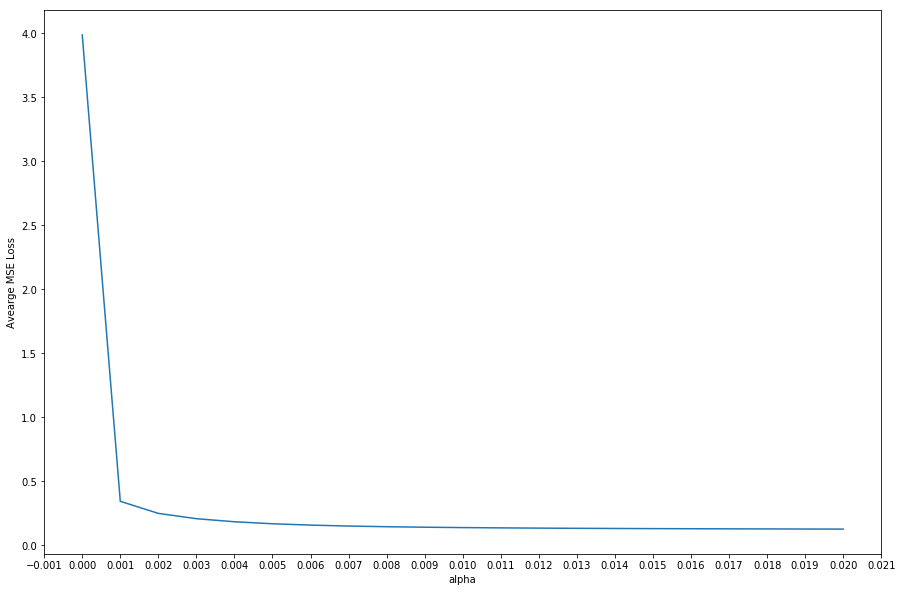

In [552]:
# Plot Tuning Results
plt.figure(figsize=(15,10))
plt.plot(list(i*0.001 for i in range(21)) ,loss)
plt.xlabel('alpha')
plt.ylabel('Avearge MSE Loss')
ax = plt.subplot(1, 1, 1)
ax.xaxis.set_major_locator(MaxNLocator(nbins=25))

In [116]:
# Optimal alpha = 0.001
# Test Performance
loss_SUM = 0.0
coef_list = []
for tic in tic_available:
    temp = get_data_by_date_range(df_clean, 20001031, 20191231,tic)
    temp = temp.drop(['tic'], axis =1)
    temp['trt1m'] = temp['trt1m']/100
    temp['trt1m'] = temp['trt1m'].shift(-1)
    temp = temp.dropna()
    temp.iloc[:,2:] = (temp.iloc[:,2:]-temp.iloc[:,2:].mean())/temp.iloc[:,2:].std()
    temp=temp.dropna(axis=1)

    train_index = int(0.4*len(temp))
    validate_index = int(0.8*len(temp))
    train = temp.iloc[:train_index,]
    validate = temp.iloc[train_index:validate_index,]
    test = temp.iloc[validate_index:,]    
    reg =  Lasso(alpha=0.001).fit(train.iloc[:,2:], train['trt1m'])
    coef_list.append((train.columns, reg.coef_))
    predict_x = reg.predict(test.iloc[:,2:])
    loss_SUM+=np.sqrt(sum(np.power(predict_x-test['trt1m'].values,2))/len(test))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [241]:
# Total Loss
loss_SUM

596.8262178073807

In [528]:
# Plot Lasso Variable Importance
dict_coef = {}
for ind, coef in coef_list:
    h = ind[2:]
    for j in range(len(h)):
        dict_coef[h[j]]= dict_coef.get(h[j],0) + abs(coef[j])        

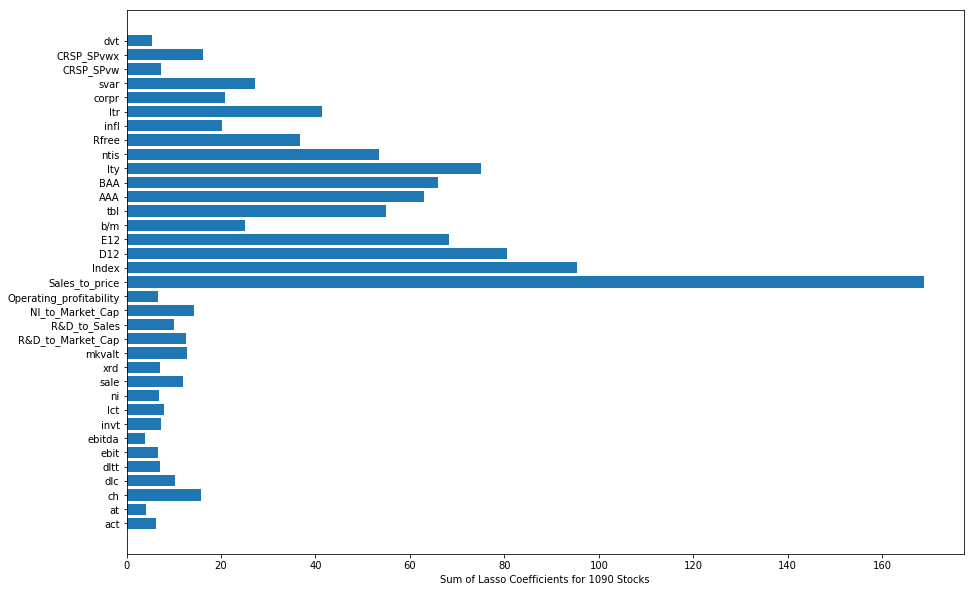

In [553]:
tick_label = list(dict_coef.keys())
scalar = list(range(len(tick_label)))
height = [dict_coef[k] for k in tick_label]
plt.figure(figsize=(15,10))
plt.barh(scalar, height,linewidth = 10, tick_label= tick_label)
plt.xlabel('Sum of Lasso Coefficients for 1090 Stocks')

In [239]:
# Lasso for a Chosen Ticker
alpha = 0.001
temp = get_data_by_date_range(df_clean, 20001031, 20191231,'MSFT')
temp = temp.drop(['tic'], axis =1)
temp['trt1m'] = temp['trt1m']/100
temp['trt1m'] = temp['trt1m'].shift(-1)
temp = temp.dropna()
temp.iloc[:,2:] = (temp.iloc[:,2:]-temp.iloc[:,2:].mean())/temp.iloc[:,2:].std()
temp=temp.dropna(axis=1)

train_index = int(0.4*len(temp))
validate_index = int(0.8*len(temp))
train = temp.iloc[:train_index,]
validate = temp.iloc[train_index:validate_index,]
test = temp.iloc[validate_index:,]    
reg =  Lasso(alpha=alpha).fit(train.iloc[:,2:], train['trt1m'])
predict_x = reg.predict(test.iloc[:,2:])
print('----LOSS----')
print(np.sqrt(sum(np.power(predict_x.flatten()-test['trt1m'].values,2))/len(test)))

----LOSS----
0.579055073779367


/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


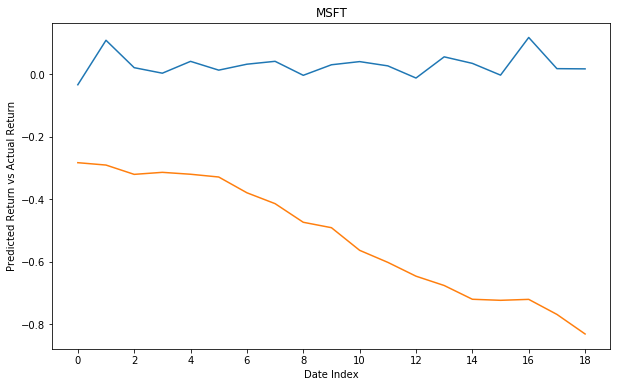

In [240]:
# Visualize Actual vs Predicted Return
plt.figure(figsize=(10,6))
plt.plot(test['trt1m'].values)
plt.plot(predict_x)
plt.title('MSFT')
plt.xlabel('Date Index')
plt.ylabel('Predicted Return vs Actual Return')
ax = plt.subplot(1, 1, 1)
ax.xaxis.set_major_locator(MaxNLocator(nbins=10))

## Neural Network

In [30]:
# Set Seed For Neural Network
import numpy as np
# Random Seeds MUST Be Set Before Importing keras & tensorflow
my_seed = 123
np.random.seed(my_seed)
import random 
random.seed(my_seed)
import tensorflow as tf
tf.set_random_seed(my_seed)

In [234]:
# Neural Network
# Example of L2 on a Dense Layer

# Import Packages
from keras.layers import Dense
from keras.regularizers import l2
from keras.layers import Dense, Activation
from keras.models import Sequential

# Set L2 Penalty
penalty = 0.001

# Construct a Dataframe for a Chosen Ticker
temp = get_data_by_date_range(df_clean, 20001031, 20191231, 'MSFT')
temp = temp.drop(['tic'], axis =1)
temp['trt1m'] = temp['trt1m']/100
temp['trt1m'] = temp['trt1m'].shift(-1)
temp = temp.dropna()
temp.iloc[:,2:] = (temp.iloc[:,2:]-temp.iloc[:,2:].mean())/temp.iloc[:,2:].std()
temp=temp.dropna(axis=1)

# Separate Data into 40% Training, 40% Validation, 20% Test
train_index = int(0.4*len(temp))
validate_index = int(0.8*len(temp))
train = temp.iloc[:train_index,]
validate = temp.iloc[train_index:validate_index,]
test = temp.iloc[validate_index:,] 

# Adjust Input Length
input_length= len(temp.columns)-2

# Single Layer Model
model1 = Sequential()
model1.add(Dense(32, activation = 'sigmoid', input_dim = input_length,
                 kernel_regularizer=l2(penalty), bias_regularizer=l2(penalty)))
model1.add(Dense(units = 1))
model1.compile(optimizer='adam',
              loss='mean_squared_error')

# 2 Layer Model
model2 = Sequential()
model2.add(Dense(32, activation = 'sigmoid', input_dim = input_length,
                 kernel_regularizer=l2(penalty), bias_regularizer=l2(penalty)))
model2.add(Dense(16, activation = 'sigmoid', input_dim = input_length,
                 kernel_regularizer=l2(penalty), bias_regularizer=l2(penalty)))
model2.add(Dense(units = 1))
model2.compile(optimizer='adam',
              loss='mean_squared_error')

# 3 Layer Model
model3 = Sequential()
model3.add(Dense(32, activation = 'sigmoid', input_dim = input_length,
                 kernel_regularizer=l2(penalty), bias_regularizer=l2(penalty)))
model3.add(Dense(16, activation = 'sigmoid', input_dim = input_length,
                 kernel_regularizer=l2(penalty), bias_regularizer=l2(penalty)))
model3.add(Dense(8, activation = 'sigmoid', input_dim = input_length,
                 kernel_regularizer=l2(penalty), bias_regularizer=l2(penalty)))
model3.add(Dense(units = 1))
model3.compile(optimizer='adam',
              loss='mean_squared_error')

# 4 Layer Model
model4 = Sequential()
model4.add(Dense(32, activation = 'sigmoid', input_dim = input_length,
                 kernel_regularizer=l2(penalty), bias_regularizer=l2(penalty)))
model4.add(Dense(16, activation = 'sigmoid', input_dim = input_length,
                 kernel_regularizer=l2(penalty), bias_regularizer=l2(penalty)))
model4.add(Dense(8, activation = 'sigmoid', input_dim = input_length,
                 kernel_regularizer=l2(penalty), bias_regularizer=l2(penalty)))
model4.add(Dense(4, activation = 'sigmoid', input_dim = input_length,
                 kernel_regularizer=l2(penalty), bias_regularizer=l2(penalty)))
model4.add(Dense(units = 1))
model4.compile(optimizer='adam',
              loss='mean_squared_error')

# 5 Layer Model
model5 = Sequential()
model5.add(Dense(32, activation = 'sigmoid', input_dim = input_length,
                 kernel_regularizer=l2(penalty), bias_regularizer=l2(penalty)))
model5.add(Dense(16, activation = 'sigmoid', input_dim = input_length,
                 kernel_regularizer=l2(penalty), bias_regularizer=l2(penalty)))
model5.add(Dense(8, activation = 'sigmoid', input_dim = input_length,
                 kernel_regularizer=l2(penalty), bias_regularizer=l2(penalty)))
model5.add(Dense(4, activation = 'sigmoid', input_dim = input_length,
                 kernel_regularizer=l2(penalty), bias_regularizer=l2(penalty)))
model5.add(Dense(2, activation = 'sigmoid', input_dim = input_length,
                 kernel_regularizer=l2(penalty), bias_regularizer=l2(penalty)))
model5.add(Dense(units = 1))
model5.compile(optimizer='adam',
              loss='mean_squared_error')

In [12]:
# Fuction to Get Model - Can Be Easily Used when Used Looping through Stocks
# keep the Above Cell just for Quick Test
# This Function is a More Decent Way We Should Code

def get_model(i, act):
    model_list = []
    model1 = Sequential()
    model1.add(Dense(32, activation = act, input_dim = input_length,
                     kernel_regularizer=l2(penalty), bias_regularizer=l2(penalty)))
    model1.add(Dense(units = 1))
    model1.compile(optimizer='adam',
                  loss='mean_squared_error')
    model_list.append(model1)

    model2 = Sequential()
    model2.add(Dense(32, activation = act, input_dim = input_length,
                     kernel_regularizer=l2(penalty), bias_regularizer=l2(penalty)))
    model2.add(Dense(16, activation = act, input_dim = input_length,
                     kernel_regularizer=l2(penalty), bias_regularizer=l2(penalty)))
    model2.add(Dense(units = 1))
    model2.compile(optimizer='adam',
                  loss='mean_squared_error')
    model_list.append(model2)


    model3 = Sequential()
    model3.add(Dense(32, activation = act, input_dim = input_length,
                     kernel_regularizer=l2(penalty), bias_regularizer=l2(penalty)))
    model3.add(Dense(16, activation = act, input_dim = input_length,
                     kernel_regularizer=l2(penalty), bias_regularizer=l2(penalty)))
    model3.add(Dense(8, activation = act, input_dim = input_length,
                     kernel_regularizer=l2(penalty), bias_regularizer=l2(penalty)))
    model3.add(Dense(units = 1))
    model3.compile(optimizer='adam',
                  loss='mean_squared_error')
    model_list.append(model3)

    model4 = Sequential()
    model4.add(Dense(32, activation = act, input_dim = input_length,
                     kernel_regularizer=l2(penalty), bias_regularizer=l2(penalty)))
    model4.add(Dense(16, activation = act, input_dim = input_length,
                     kernel_regularizer=l2(penalty), bias_regularizer=l2(penalty)))
    model4.add(Dense(8, activation = act, input_dim = input_length,
                     kernel_regularizer=l2(penalty), bias_regularizer=l2(penalty)))
    model4.add(Dense(4, activation = act, input_dim = input_length,
                     kernel_regularizer=l2(penalty), bias_regularizer=l2(penalty)))
    model4.add(Dense(units = 1))
    model4.compile(optimizer='adam',
                  loss='mean_squared_error')
    model_list.append(model4)


    model5 = Sequential()
    model5.add(Dense(32, activation = act, input_dim = input_length,
                     kernel_regularizer=l2(penalty), bias_regularizer=l2(penalty)))
    model5.add(Dense(16, activation = act, input_dim = input_length,
                     kernel_regularizer=l2(penalty), bias_regularizer=l2(penalty)))
    model5.add(Dense(8, activation = act, input_dim = input_length,
                     kernel_regularizer=l2(penalty), bias_regularizer=l2(penalty)))
    model5.add(Dense(4, activation = act, input_dim = input_length,
                     kernel_regularizer=l2(penalty), bias_regularizer=l2(penalty)))
    model5.add(Dense(2, activation = act, input_dim = input_length,
                     kernel_regularizer=l2(penalty), bias_regularizer=l2(penalty)))
    model5.add(Dense(units = 1))
    model5.compile(optimizer='adam',
                  loss='mean_squared_error')
    model_list.append(model5)
    return model_list[i-1]

In [14]:
# No Past Return Tuning Loop
# Takes Ages to Loop Through 1000 Stocks
# Test for Stock 77

epoch_list = [100, 200, 500]
acviation_function = ['sigmoid', 'relu']
lost= {}
model_index = 1
for epoch in epoch_list:
    for act in acviation_function:
        loss_sum =0
        for tic in tic_available[[77]]:
            penalty = 0.0001
            temp = get_data_by_date_range(df_clean, 20001031, 20191231,tic)
            temp = temp.drop(['tic'], axis =1)
            temp['trt1m'] = temp['trt1m']/100
            temp['trt1m'] = temp['trt1m'].shift(-1)
            temp = temp.dropna()
            temp.iloc[:,2:] = (temp.iloc[:,2:]-temp.iloc[:,2:].mean())/temp.iloc[:,2:].std()
            temp=temp.dropna(axis=1)

            train_index = int(0.4*len(temp))
            validate_index = int(0.8*len(temp))
            train = temp.iloc[:train_index,]
            validate = temp.iloc[train_index:validate_index,]
            test = temp.iloc[validate_index:,] 

            input_length= len(temp.columns)-2

            model = get_model(model_index, act )

            model.fit(train.iloc[:,2:], train['trt1m'], batch_size = 10, epochs = epoch)
            predict_x= model.predict(validate.iloc[:,2:])
            loss_sum += (np.sqrt(sum(np.power(predict_x.flatten()-validate['trt1m'].values,2))/len(validate)))
        lost['epoch:'+ str(epoch) + ' '+act] = loss_sum
        
pd.DataFrame.from_dict(lost, orient='index',columns =['loss model ' + str(model_index)])        

Epoch 1/100
38/38 [==============================] - 1s 17ms/step - loss: 0.8306
Epoch 2/100
38/38 [==============================] - 0s 292us/step - loss: 0.5809
Epoch 3/100
38/38 [==============================] - 0s 279us/step - loss: 0.3780
Epoch 4/100
38/38 [==============================] - 0s 301us/step - loss: 0.2306
Epoch 5/100
38/38 [==============================] - 0s 354us/step - loss: 0.1444
Epoch 6/100
38/38 [==============================] - 0s 310us/step - loss: 0.0820
Epoch 7/100
38/38 [==============================] - 0s 252us/step - loss: 0.0528
Epoch 8/100
38/38 [==============================] - 0s 370us/step - loss: 0.0419
Epoch 9/100
38/38 [==============================] - 0s 427us/step - loss: 0.0416
Epoch 10/100
38/38 [==============================] - 0s 411us/step - loss: 0.0402
Epoch 11/100
38/38 [==============================] - 0s 338us/step - loss: 0.0372
Epoch 12/100
38/38 [==============================] - 0s 320us/step - loss: 0.0328
Epoch 13/100
3

38/38 [==============================] - 0s 233us/step - loss: 0.0059
Epoch 100/100
38/38 [==============================] - 0s 257us/step - loss: 0.0058
Epoch 1/100
38/38 [==============================] - 1s 22ms/step - loss: 0.2375
Epoch 2/100
38/38 [==============================] - 0s 338us/step - loss: 0.1641
Epoch 3/100
38/38 [==============================] - 0s 294us/step - loss: 0.1152
Epoch 4/100
38/38 [==============================] - 0s 318us/step - loss: 0.0886
Epoch 5/100
38/38 [==============================] - 0s 294us/step - loss: 0.0690
Epoch 6/100
38/38 [==============================] - 0s 271us/step - loss: 0.0585
Epoch 7/100
38/38 [==============================] - 0s 298us/step - loss: 0.0504
Epoch 8/100
38/38 [==============================] - 0s 283us/step - loss: 0.0440
Epoch 9/100
38/38 [==============================] - 0s 297us/step - loss: 0.0390
Epoch 10/100
38/38 [==============================] - 0s 306us/step - loss: 0.0335
Epoch 11/100
38/38 [======

38/38 [==============================] - 0s 339us/step - loss: 0.0031
Epoch 98/100
38/38 [==============================] - 0s 320us/step - loss: 0.0031
Epoch 99/100
38/38 [==============================] - 0s 340us/step - loss: 0.0031
Epoch 100/100
38/38 [==============================] - 0s 297us/step - loss: 0.0031
Epoch 1/200
38/38 [==============================] - 1s 21ms/step - loss: 0.0644
Epoch 2/200
38/38 [==============================] - 0s 305us/step - loss: 0.0279
Epoch 3/200
38/38 [==============================] - 0s 327us/step - loss: 0.0232
Epoch 4/200
38/38 [==============================] - 0s 326us/step - loss: 0.0189
Epoch 5/200
38/38 [==============================] - 0s 324us/step - loss: 0.0125
Epoch 6/200
38/38 [==============================] - 0s 362us/step - loss: 0.0112
Epoch 7/200
38/38 [==============================] - 0s 343us/step - loss: 0.0118
Epoch 8/200
38/38 [==============================] - 0s 348us/step - loss: 0.0107
Epoch 9/200
38/38 [======

Epoch 96/200
38/38 [==============================] - 0s 297us/step - loss: 0.0044
Epoch 97/200
38/38 [==============================] - 0s 248us/step - loss: 0.0045
Epoch 98/200
38/38 [==============================] - 0s 293us/step - loss: 0.0045
Epoch 99/200
38/38 [==============================] - 0s 362us/step - loss: 0.0044
Epoch 100/200
38/38 [==============================] - 0s 337us/step - loss: 0.0044
Epoch 101/200
38/38 [==============================] - 0s 366us/step - loss: 0.0044
Epoch 102/200
38/38 [==============================] - 0s 274us/step - loss: 0.0044
Epoch 103/200
38/38 [==============================] - 0s 288us/step - loss: 0.0043
Epoch 104/200
38/38 [==============================] - 0s 280us/step - loss: 0.0044
Epoch 105/200
38/38 [==============================] - 0s 275us/step - loss: 0.0043
Epoch 106/200
38/38 [==============================] - 0s 310us/step - loss: 0.0043
Epoch 107/200
38/38 [==============================] - 0s 341us/step - loss: 0.0

38/38 [==============================] - 0s 305us/step - loss: 0.0035
Epoch 194/200
38/38 [==============================] - 0s 316us/step - loss: 0.0035
Epoch 195/200
38/38 [==============================] - 0s 348us/step - loss: 0.0035
Epoch 196/200
38/38 [==============================] - 0s 315us/step - loss: 0.0036
Epoch 197/200
38/38 [==============================] - 0s 349us/step - loss: 0.0035
Epoch 198/200
38/38 [==============================] - 0s 379us/step - loss: 0.0035
Epoch 199/200
38/38 [==============================] - 0s 328us/step - loss: 0.0035
Epoch 200/200
38/38 [==============================] - 0s 340us/step - loss: 0.0035
Epoch 1/200
38/38 [==============================] - 1s 24ms/step - loss: 2.7728
Epoch 2/200
38/38 [==============================] - 0s 363us/step - loss: 1.6700
Epoch 3/200
38/38 [==============================] - 0s 332us/step - loss: 1.0319
Epoch 4/200
38/38 [==============================] - 0s 351us/step - loss: 0.6212
Epoch 5/200
38/

38/38 [==============================] - 0s 376us/step - loss: 0.0044
Epoch 92/200
38/38 [==============================] - 0s 344us/step - loss: 0.0044
Epoch 93/200
38/38 [==============================] - 0s 333us/step - loss: 0.0044
Epoch 94/200
38/38 [==============================] - 0s 324us/step - loss: 0.0043
Epoch 95/200
38/38 [==============================] - 0s 342us/step - loss: 0.0043
Epoch 96/200
38/38 [==============================] - 0s 365us/step - loss: 0.0042
Epoch 97/200
38/38 [==============================] - 0s 362us/step - loss: 0.0042
Epoch 98/200
38/38 [==============================] - 0s 394us/step - loss: 0.0042
Epoch 99/200
38/38 [==============================] - 0s 349us/step - loss: 0.0041
Epoch 100/200
38/38 [==============================] - 0s 342us/step - loss: 0.0041
Epoch 101/200
38/38 [==============================] - 0s 328us/step - loss: 0.0040
Epoch 102/200
38/38 [==============================] - 0s 289us/step - loss: 0.0040
Epoch 103/200


38/38 [==============================] - 0s 310us/step - loss: 0.0031
Epoch 189/200
38/38 [==============================] - 0s 379us/step - loss: 0.0031
Epoch 190/200
38/38 [==============================] - 0s 327us/step - loss: 0.0031
Epoch 191/200
38/38 [==============================] - 0s 302us/step - loss: 0.0031
Epoch 192/200
38/38 [==============================] - 0s 389us/step - loss: 0.0031
Epoch 193/200
38/38 [==============================] - 0s 290us/step - loss: 0.0031
Epoch 194/200
38/38 [==============================] - 0s 419us/step - loss: 0.0030
Epoch 195/200
38/38 [==============================] - 0s 406us/step - loss: 0.0030
Epoch 196/200
38/38 [==============================] - 0s 374us/step - loss: 0.0030
Epoch 197/200
38/38 [==============================] - 0s 368us/step - loss: 0.0030
Epoch 198/200
38/38 [==============================] - 0s 428us/step - loss: 0.0030
Epoch 199/200
38/38 [==============================] - 0s 365us/step - loss: 0.0030
Epoch 

38/38 [==============================] - 0s 336us/step - loss: 0.0051
Epoch 87/500
38/38 [==============================] - 0s 423us/step - loss: 0.0051
Epoch 88/500
38/38 [==============================] - 0s 375us/step - loss: 0.0051
Epoch 89/500
38/38 [==============================] - 0s 386us/step - loss: 0.0051
Epoch 90/500
38/38 [==============================] - 0s 406us/step - loss: 0.0050
Epoch 91/500
38/38 [==============================] - 0s 377us/step - loss: 0.0050
Epoch 92/500
38/38 [==============================] - 0s 391us/step - loss: 0.0050
Epoch 93/500
38/38 [==============================] - 0s 422us/step - loss: 0.0050
Epoch 94/500
38/38 [==============================] - 0s 435us/step - loss: 0.0049
Epoch 95/500
38/38 [==============================] - 0s 538us/step - loss: 0.0050
Epoch 96/500
38/38 [==============================] - 0s 441us/step - loss: 0.0049
Epoch 97/500
38/38 [==============================] - 0s 431us/step - loss: 0.0049
Epoch 98/500
38/3

38/38 [==============================] - 0s 330us/step - loss: 0.0038
Epoch 184/500
38/38 [==============================] - 0s 400us/step - loss: 0.0038
Epoch 185/500
38/38 [==============================] - 0s 332us/step - loss: 0.0038
Epoch 186/500
38/38 [==============================] - 0s 435us/step - loss: 0.0038
Epoch 187/500
38/38 [==============================] - 0s 318us/step - loss: 0.0038
Epoch 188/500
38/38 [==============================] - 0s 353us/step - loss: 0.0038
Epoch 189/500
38/38 [==============================] - 0s 393us/step - loss: 0.0037
Epoch 190/500
38/38 [==============================] - 0s 322us/step - loss: 0.0038
Epoch 191/500
38/38 [==============================] - 0s 382us/step - loss: 0.0037
Epoch 192/500
38/38 [==============================] - 0s 392us/step - loss: 0.0037
Epoch 193/500
38/38 [==============================] - 0s 314us/step - loss: 0.0037
Epoch 194/500
38/38 [==============================] - 0s 385us/step - loss: 0.0037
Epoch 

38/38 [==============================] - 0s 390us/step - loss: 0.0031
Epoch 281/500
38/38 [==============================] - 0s 343us/step - loss: 0.0031
Epoch 282/500
38/38 [==============================] - 0s 402us/step - loss: 0.0030
Epoch 283/500
38/38 [==============================] - 0s 353us/step - loss: 0.0031
Epoch 284/500
38/38 [==============================] - 0s 316us/step - loss: 0.0031
Epoch 285/500
38/38 [==============================] - 0s 372us/step - loss: 0.0031
Epoch 286/500
38/38 [==============================] - 0s 365us/step - loss: 0.0030
Epoch 287/500
38/38 [==============================] - 0s 381us/step - loss: 0.0031
Epoch 288/500
38/38 [==============================] - 0s 360us/step - loss: 0.0031
Epoch 289/500
38/38 [==============================] - 0s 352us/step - loss: 0.0031
Epoch 290/500
38/38 [==============================] - 0s 329us/step - loss: 0.0030
Epoch 291/500
38/38 [==============================] - 0s 325us/step - loss: 0.0031
Epoch 

38/38 [==============================] - 0s 288us/step - loss: 0.0026
Epoch 378/500
38/38 [==============================] - 0s 355us/step - loss: 0.0026
Epoch 379/500
38/38 [==============================] - 0s 332us/step - loss: 0.0026
Epoch 380/500
38/38 [==============================] - 0s 374us/step - loss: 0.0026
Epoch 381/500
38/38 [==============================] - 0s 354us/step - loss: 0.0026
Epoch 382/500
38/38 [==============================] - 0s 390us/step - loss: 0.0025
Epoch 383/500
38/38 [==============================] - 0s 394us/step - loss: 0.0025
Epoch 384/500
38/38 [==============================] - 0s 339us/step - loss: 0.0026
Epoch 385/500
38/38 [==============================] - 0s 339us/step - loss: 0.0025
Epoch 386/500
38/38 [==============================] - 0s 395us/step - loss: 0.0025
Epoch 387/500
38/38 [==============================] - 0s 373us/step - loss: 0.0025
Epoch 388/500
38/38 [==============================] - 0s 337us/step - loss: 0.0025
Epoch 

38/38 [==============================] - 0s 311us/step - loss: 0.0022
Epoch 475/500
38/38 [==============================] - 0s 297us/step - loss: 0.0022
Epoch 476/500
38/38 [==============================] - 0s 331us/step - loss: 0.0022
Epoch 477/500
38/38 [==============================] - 0s 274us/step - loss: 0.0022
Epoch 478/500
38/38 [==============================] - 0s 379us/step - loss: 0.0022
Epoch 479/500
38/38 [==============================] - 0s 366us/step - loss: 0.0022
Epoch 480/500
38/38 [==============================] - 0s 408us/step - loss: 0.0022
Epoch 481/500
38/38 [==============================] - 0s 404us/step - loss: 0.0021
Epoch 482/500
38/38 [==============================] - 0s 379us/step - loss: 0.0022
Epoch 483/500
38/38 [==============================] - 0s 303us/step - loss: 0.0022
Epoch 484/500
38/38 [==============================] - 0s 390us/step - loss: 0.0022
Epoch 485/500
38/38 [==============================] - 0s 346us/step - loss: 0.0023
Epoch 

38/38 [==============================] - 0s 431us/step - loss: 0.0043
Epoch 73/500
38/38 [==============================] - 0s 415us/step - loss: 0.0043
Epoch 74/500
38/38 [==============================] - 0s 474us/step - loss: 0.0043
Epoch 75/500
38/38 [==============================] - 0s 412us/step - loss: 0.0042
Epoch 76/500
38/38 [==============================] - 0s 423us/step - loss: 0.0042
Epoch 77/500
38/38 [==============================] - 0s 435us/step - loss: 0.0041
Epoch 78/500
38/38 [==============================] - 0s 466us/step - loss: 0.0041
Epoch 79/500
38/38 [==============================] - 0s 418us/step - loss: 0.0040
Epoch 80/500
38/38 [==============================] - 0s 402us/step - loss: 0.0040
Epoch 81/500
38/38 [==============================] - 0s 419us/step - loss: 0.0040
Epoch 82/500
38/38 [==============================] - 0s 368us/step - loss: 0.0039
Epoch 83/500
38/38 [==============================] - 0s 349us/step - loss: 0.0039
Epoch 84/500
38/3

38/38 [==============================] - 0s 377us/step - loss: 0.0032
Epoch 170/500
38/38 [==============================] - 0s 399us/step - loss: 0.0032
Epoch 171/500
38/38 [==============================] - 0s 393us/step - loss: 0.0032
Epoch 172/500
38/38 [==============================] - 0s 365us/step - loss: 0.0032
Epoch 173/500
38/38 [==============================] - 0s 361us/step - loss: 0.0032
Epoch 174/500
38/38 [==============================] - 0s 362us/step - loss: 0.0032
Epoch 175/500
38/38 [==============================] - 0s 362us/step - loss: 0.0031
Epoch 176/500
38/38 [==============================] - 0s 399us/step - loss: 0.0031
Epoch 177/500
38/38 [==============================] - 0s 389us/step - loss: 0.0031
Epoch 178/500
38/38 [==============================] - 0s 374us/step - loss: 0.0031
Epoch 179/500
38/38 [==============================] - 0s 363us/step - loss: 0.0031
Epoch 180/500
38/38 [==============================] - 0s 353us/step - loss: 0.0031
Epoch 

38/38 [==============================] - 0s 328us/step - loss: 0.0030
Epoch 267/500
38/38 [==============================] - 0s 322us/step - loss: 0.0030
Epoch 268/500
38/38 [==============================] - 0s 366us/step - loss: 0.0030
Epoch 269/500
38/38 [==============================] - 0s 370us/step - loss: 0.0030
Epoch 270/500
38/38 [==============================] - 0s 405us/step - loss: 0.0030
Epoch 271/500
38/38 [==============================] - 0s 380us/step - loss: 0.0030
Epoch 272/500
38/38 [==============================] - 0s 440us/step - loss: 0.0029
Epoch 273/500
38/38 [==============================] - 0s 354us/step - loss: 0.0029
Epoch 274/500
38/38 [==============================] - 0s 330us/step - loss: 0.0029
Epoch 275/500
38/38 [==============================] - 0s 365us/step - loss: 0.0029
Epoch 276/500
38/38 [==============================] - 0s 345us/step - loss: 0.0029
Epoch 277/500
38/38 [==============================] - 0s 365us/step - loss: 0.0029
Epoch 

38/38 [==============================] - 0s 388us/step - loss: 0.0028
Epoch 364/500
38/38 [==============================] - 0s 378us/step - loss: 0.0028
Epoch 365/500
38/38 [==============================] - 0s 304us/step - loss: 0.0028
Epoch 366/500
38/38 [==============================] - 0s 366us/step - loss: 0.0028
Epoch 367/500
38/38 [==============================] - 0s 368us/step - loss: 0.0028
Epoch 368/500
38/38 [==============================] - 0s 400us/step - loss: 0.0028
Epoch 369/500
38/38 [==============================] - 0s 279us/step - loss: 0.0028
Epoch 370/500
38/38 [==============================] - 0s 338us/step - loss: 0.0028
Epoch 371/500
38/38 [==============================] - 0s 355us/step - loss: 0.0028
Epoch 372/500
38/38 [==============================] - 0s 360us/step - loss: 0.0028
Epoch 373/500
38/38 [==============================] - 0s 357us/step - loss: 0.0028
Epoch 374/500
38/38 [==============================] - 0s 350us/step - loss: 0.0028
Epoch 

38/38 [==============================] - 0s 461us/step - loss: 0.0026
Epoch 461/500
38/38 [==============================] - 0s 328us/step - loss: 0.0026
Epoch 462/500
38/38 [==============================] - 0s 406us/step - loss: 0.0026
Epoch 463/500
38/38 [==============================] - 0s 353us/step - loss: 0.0026
Epoch 464/500
38/38 [==============================] - 0s 375us/step - loss: 0.0026
Epoch 465/500
38/38 [==============================] - 0s 382us/step - loss: 0.0026
Epoch 466/500
38/38 [==============================] - 0s 371us/step - loss: 0.0026
Epoch 467/500
38/38 [==============================] - 0s 366us/step - loss: 0.0026
Epoch 468/500
38/38 [==============================] - 0s 421us/step - loss: 0.0026
Epoch 469/500
38/38 [==============================] - 0s 458us/step - loss: 0.0026
Epoch 470/500
38/38 [==============================] - 0s 483us/step - loss: 0.0026
Epoch 471/500
38/38 [==============================] - 0s 435us/step - loss: 0.0026
Epoch 

,loss model 1
epoch:100 sigmoid,0.241335
epoch:100 relu,0.306361
epoch:200 sigmoid,0.077345
epoch:200 relu,0.638525
epoch:500 sigmoid,0.270123
epoch:500 relu,0.340625


In [579]:
# Past Three Month Return Tuning Loop
# Takes Ages to Loop Through 1000 Stocks
# Test for Stock 77

epoch_list = [100, 200, 500]
acviation_function = ['sigmoid', 'relu']
lost= {}
model_index = 1
for epoch in epoch_list:
    for act in acviation_function:
        loss_sum =0
        for tic in tic_available[[77]]:
            penalty = 0.0001
            temp = get_data_by_date_range(df_clean, 20001031, 20191231,tic)
            temp = temp.drop(['tic'], axis =1)
            temp['trt1m'] = temp['trt1m']/100
            temp['past_trt1m_1'] = temp['trt1m']
            temp['past_trt1m_2'] = temp['trt1m'].shift(1)
            temp['past_trt1m_3'] = temp['trt1m'].shift(2)
            temp['trt1m'] = temp['trt1m'].shift(-1)
            temp = temp.dropna()
            temp.iloc[:,2:] = (temp.iloc[:,2:]-temp.iloc[:,2:].mean())/temp.iloc[:,2:].std()
            temp=temp.dropna(axis=1)

            train_index = int(0.4*len(temp))
            validate_index = int(0.8*len(temp))
            train = temp.iloc[:train_index,]
            validate = temp.iloc[train_index:validate_index,]
            test = temp.iloc[validate_index:,] 

            input_length= len(temp.columns)-2

            model = get_model(model_index, act)

            model.fit(train.iloc[:,2:], train['trt1m'], batch_size = 10, epochs = epoch)
            predict_x= model.predict(validate.iloc[:,2:])
            loss_sum += (np.sqrt(sum(np.power(predict_x.flatten()-validate['trt1m'].values,2))/len(validate)))
        lost['epoch:'+ str(epoch) + ' '+act] = loss_sum
        
pd.DataFrame.from_dict(lost, orient='index',columns =['loss model ' + str(model_index)])        

Epoch 1/100
37/37 [==============================] - 5s 148ms/step - loss: 0.2063
Epoch 2/100
37/37 [==============================] - 0s 868us/step - loss: 0.1061
Epoch 3/100
37/37 [==============================] - 0s 871us/step - loss: 0.0703
Epoch 4/100
37/37 [==============================] - 0s 838us/step - loss: 0.0634
Epoch 5/100
37/37 [==============================] - 0s 929us/step - loss: 0.0607
Epoch 6/100
37/37 [==============================] - 0s 873us/step - loss: 0.0548
Epoch 7/100
37/37 [==============================] - 0s 893us/step - loss: 0.0464
Epoch 8/100
37/37 [==============================] - 0s 853us/step - loss: 0.0400
Epoch 9/100
37/37 [==============================] - 0s 945us/step - loss: 0.0365
Epoch 10/100
37/37 [==============================] - 0s 943us/step - loss: 0.0344
Epoch 11/100
37/37 [==============================] - 0s 894us/step - loss: 0.0313
Epoch 12/100
37/37 [==============================] - 0s 920us/step - loss: 0.0294
Epoch 13/100


Epoch 100/100
37/37 [==============================] - 0s 816us/step - loss: 0.0067
Epoch 1/100
37/37 [==============================] - 5s 134ms/step - loss: 0.3729
Epoch 2/100
37/37 [==============================] - 0s 927us/step - loss: 0.2571
Epoch 3/100
37/37 [==============================] - 0s 664us/step - loss: 0.1887
Epoch 4/100
37/37 [==============================] - 0s 827us/step - loss: 0.1529
Epoch 5/100
37/37 [==============================] - 0s 901us/step - loss: 0.1168
Epoch 6/100
37/37 [==============================] - 0s 942us/step - loss: 0.0922
Epoch 7/100
37/37 [==============================] - 0s 898us/step - loss: 0.0724
Epoch 8/100
37/37 [==============================] - 0s 979us/step - loss: 0.0597
Epoch 9/100
37/37 [==============================] - 0s 913us/step - loss: 0.0475
Epoch 10/100
37/37 [==============================] - 0s 900us/step - loss: 0.0407
Epoch 11/100
37/37 [==============================] - 0s 918us/step - loss: 0.0336
Epoch 12/100

37/37 [==============================] - 0s 818us/step - loss: 0.0103
Epoch 98/200
37/37 [==============================] - 0s 854us/step - loss: 0.0104
Epoch 99/200
37/37 [==============================] - 0s 890us/step - loss: 0.0103
Epoch 100/200
37/37 [==============================] - 0s 865us/step - loss: 0.0102
Epoch 101/200
37/37 [==============================] - 0s 859us/step - loss: 0.0101
Epoch 102/200
37/37 [==============================] - 0s 862us/step - loss: 0.0101
Epoch 103/200
37/37 [==============================] - 0s 825us/step - loss: 0.0101
Epoch 104/200
37/37 [==============================] - 0s 878us/step - loss: 0.0100
Epoch 105/200
37/37 [==============================] - 0s 846us/step - loss: 0.0100
Epoch 106/200
37/37 [==============================] - 0s 793us/step - loss: 0.0099
Epoch 107/200
37/37 [==============================] - 0s 770us/step - loss: 0.0098
Epoch 108/200
37/37 [==============================] - 0s 904us/step - loss: 0.0098
Epoch 10

37/37 [==============================] - 0s 878us/step - loss: 0.0038
Epoch 95/200
37/37 [==============================] - 0s 900us/step - loss: 0.0038
Epoch 96/200
37/37 [==============================] - 0s 919us/step - loss: 0.0038
Epoch 97/200
37/37 [==============================] - 0s 994us/step - loss: 0.0038
Epoch 98/200
37/37 [==============================] - 0s 926us/step - loss: 0.0038
Epoch 99/200
37/37 [==============================] - 0s 994us/step - loss: 0.0037
Epoch 100/200
37/37 [==============================] - 0s 959us/step - loss: 0.0037
Epoch 101/200
37/37 [==============================] - 0s 1ms/step - loss: 0.0037
Epoch 102/200
37/37 [==============================] - 0s 934us/step - loss: 0.0037
Epoch 103/200
37/37 [==============================] - 0s 966us/step - loss: 0.0037
Epoch 104/200
37/37 [==============================] - 0s 920us/step - loss: 0.0037
Epoch 105/200
37/37 [==============================] - 0s 939us/step - loss: 0.0037
Epoch 106/200

37/37 [==============================] - 0s 800us/step - loss: 0.0061
Epoch 90/500
37/37 [==============================] - 0s 833us/step - loss: 0.0061
Epoch 91/500
37/37 [==============================] - 0s 868us/step - loss: 0.0060
Epoch 92/500
37/37 [==============================] - 0s 795us/step - loss: 0.0060
Epoch 93/500
37/37 [==============================] - 0s 851us/step - loss: 0.0059
Epoch 94/500
37/37 [==============================] - 0s 949us/step - loss: 0.0059
Epoch 95/500
37/37 [==============================] - 0s 845us/step - loss: 0.0059
Epoch 96/500
37/37 [==============================] - 0s 841us/step - loss: 0.0059
Epoch 97/500
37/37 [==============================] - 0s 868us/step - loss: 0.0061
Epoch 98/500
37/37 [==============================] - 0s 861us/step - loss: 0.0058
Epoch 99/500
37/37 [==============================] - 0s 882us/step - loss: 0.0057
Epoch 100/500
37/37 [==============================] - 0s 853us/step - loss: 0.0057
Epoch 101/500
37

37/37 [==============================] - 0s 821us/step - loss: 0.0032
Epoch 284/500
37/37 [==============================] - 0s 753us/step - loss: 0.0032
Epoch 285/500
37/37 [==============================] - 0s 857us/step - loss: 0.0032
Epoch 286/500
37/37 [==============================] - 0s 789us/step - loss: 0.0032
Epoch 287/500
37/37 [==============================] - 0s 754us/step - loss: 0.0032
Epoch 288/500
37/37 [==============================] - 0s 818us/step - loss: 0.0032
Epoch 289/500
37/37 [==============================] - 0s 806us/step - loss: 0.0032
Epoch 290/500
37/37 [==============================] - 0s 797us/step - loss: 0.0032
Epoch 291/500
37/37 [==============================] - 0s 792us/step - loss: 0.0032
Epoch 292/500
37/37 [==============================] - 0s 833us/step - loss: 0.0032
Epoch 293/500
37/37 [==============================] - 0s 919us/step - loss: 0.0032
Epoch 294/500
37/37 [==============================] - 0s 805us/step - loss: 0.0031
Epoch 

37/37 [==============================] - 0s 791us/step - loss: 0.0024
Epoch 478/500
37/37 [==============================] - 0s 786us/step - loss: 0.0024
Epoch 479/500
37/37 [==============================] - 0s 809us/step - loss: 0.0024
Epoch 480/500
37/37 [==============================] - 0s 785us/step - loss: 0.0024
Epoch 481/500
37/37 [==============================] - 0s 866us/step - loss: 0.0024
Epoch 482/500
37/37 [==============================] - 0s 812us/step - loss: 0.0024
Epoch 483/500
37/37 [==============================] - 0s 810us/step - loss: 0.0025
Epoch 484/500
37/37 [==============================] - 0s 779us/step - loss: 0.0024
Epoch 485/500
37/37 [==============================] - 0s 850us/step - loss: 0.0024
Epoch 486/500
37/37 [==============================] - 0s 832us/step - loss: 0.0024
Epoch 487/500
37/37 [==============================] - 0s 770us/step - loss: 0.0025
Epoch 488/500
37/37 [==============================] - 0s 787us/step - loss: 0.0024
Epoch 

37/37 [==============================] - 0s 873us/step - loss: 0.0031
Epoch 174/500
37/37 [==============================] - 0s 904us/step - loss: 0.0031
Epoch 175/500
37/37 [==============================] - 0s 860us/step - loss: 0.0031
Epoch 176/500
37/37 [==============================] - 0s 869us/step - loss: 0.0031
Epoch 177/500
37/37 [==============================] - 0s 858us/step - loss: 0.0031
Epoch 178/500
37/37 [==============================] - 0s 877us/step - loss: 0.0031
Epoch 179/500
37/37 [==============================] - 0s 855us/step - loss: 0.0031
Epoch 180/500
37/37 [==============================] - 0s 905us/step - loss: 0.0031
Epoch 181/500
37/37 [==============================] - 0s 880us/step - loss: 0.0031
Epoch 182/500
37/37 [==============================] - 0s 863us/step - loss: 0.0031
Epoch 183/500
37/37 [==============================] - 0s 886us/step - loss: 0.0031
Epoch 184/500
37/37 [==============================] - 0s 884us/step - loss: 0.0031
Epoch 

37/37 [==============================] - 0s 890us/step - loss: 0.0027
Epoch 368/500
37/37 [==============================] - 0s 832us/step - loss: 0.0027
Epoch 369/500
37/37 [==============================] - 0s 903us/step - loss: 0.0027
Epoch 370/500
37/37 [==============================] - 0s 858us/step - loss: 0.0027
Epoch 371/500
37/37 [==============================] - 0s 853us/step - loss: 0.0027
Epoch 372/500
37/37 [==============================] - 0s 798us/step - loss: 0.0027
Epoch 373/500
37/37 [==============================] - 0s 907us/step - loss: 0.0027
Epoch 374/500
37/37 [==============================] - 0s 961us/step - loss: 0.0027
Epoch 375/500
37/37 [==============================] - 0s 935us/step - loss: 0.0026
Epoch 376/500
37/37 [==============================] - 0s 886us/step - loss: 0.0026
Epoch 377/500
37/37 [==============================] - 0s 958us/step - loss: 0.0026
Epoch 378/500
37/37 [==============================] - 0s 890us/step - loss: 0.0026
Epoch 

,loss model 1
epoch:100 sigmoid,0.164244
epoch:100 relu,0.430325
epoch:200 sigmoid,0.338075
epoch:200 relu,0.746836
epoch:500 sigmoid,0.320709
epoch:500 relu,0.704695


In [235]:
# 3 Hidden Layer Model Test
model3.fit(train.iloc[:,2:], train['trt1m'], batch_size = 10, epochs = 200)
predict_x= model3.predict(test.iloc[:,2:])

Epoch 1/100
38/38 [==============================] - 17s 447ms/step - loss: 0.0195
Epoch 2/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0075
Epoch 3/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch 4/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0064
Epoch 5/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0063
Epoch 6/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0048
Epoch 7/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0042
Epoch 8/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0044
Epoch 9/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch 10/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0043
Epoch 11/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0041
Epoch 12/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0042
Epoch 13/100
38/38 [==============

----LOSS----
0.04152504550125855


/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


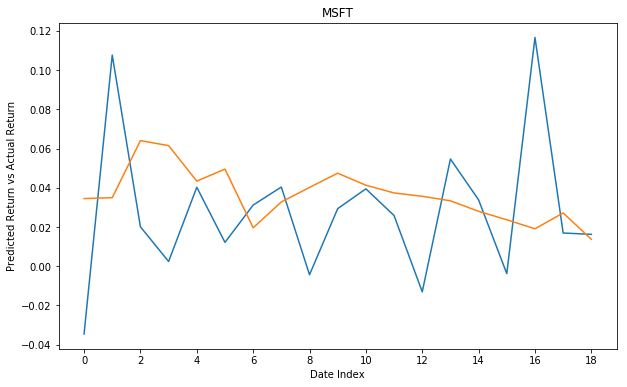

In [236]:
# Visualize Actual vs Predicted Return
print('----LOSS----')
print(np.sqrt(sum(np.power(predict_x.flatten()-test['trt1m'].values,2))/len(test)))
plt.figure(figsize=(10,6))
plt.plot(test['trt1m'].values)
plt.plot(predict_x)
plt.title('MSFT')
plt.xlabel('Date Index')
plt.ylabel('Predicted Return vs Actual Return')
ax = plt.subplot(1, 1, 1)
ax.xaxis.set_major_locator(MaxNLocator(nbins=10))

In [154]:
# Neural Network Variable Importance
# Test for 10 Stocks

tic_select_list = [77, 177, 277, 377, 477, 577, 677, 777, 877, 977]
ep = 200
act = 'sigmoid'
model_index = 3
weight_storage = []
for tic in tic_available[tic_select_list]:
    temp = get_data_by_date_range(df_clean, 20001031, 20191231, tic)
    temp = temp.drop(['tic'], axis =1)
    temp['trt1m'] = temp['trt1m']/100
    temp['trt1m'] = temp['trt1m'].shift(-1)
    temp = temp.dropna()
    temp.iloc[:,2:] = (temp.iloc[:,2:]-temp.iloc[:,2:].mean())/temp.iloc[:,2:].std()
    temp=temp.dropna(axis=1)

    train_index = int(0.4*len(temp))
    validate_index = int(0.8*len(temp))
    train = temp.iloc[:train_index,]
    validate = temp.iloc[train_index:validate_index,]
    test = temp.iloc[validate_index:,] 
    input_length= len(temp.columns)-2
    model = get_model(model_index, act)

    model.fit(train.iloc[:,2:], train['trt1m'], batch_size = 10, epochs = ep)
    weight_storage.append((train.columns[2:], np.sum(np.absolute(model.get_weights()[0]), axis = 1)))

Epoch 1/200
38/38 [==============================] - 8s 219ms/step - loss: 0.7103
Epoch 2/200
38/38 [==============================] - 0s 1ms/step - loss: 0.5551
Epoch 3/200
38/38 [==============================] - 0s 1ms/step - loss: 0.4217
Epoch 4/200
38/38 [==============================] - 0s 1ms/step - loss: 0.3130
Epoch 5/200
38/38 [==============================] - 0s 1ms/step - loss: 0.2245
Epoch 6/200
38/38 [==============================] - 0s 1ms/step - loss: 0.1559
Epoch 7/200
38/38 [==============================] - 0s 1ms/step - loss: 0.1058
Epoch 8/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0687
Epoch 9/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0446
Epoch 10/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0291
Epoch 11/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0200
Epoch 12/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0149
Epoch 13/200
38/38 [===============

38/38 [==============================] - 0s 1ms/step - loss: 0.0096
Epoch 103/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0096
Epoch 104/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0096
Epoch 105/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0095
Epoch 106/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0095
Epoch 107/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0095
Epoch 108/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0095
Epoch 109/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0095
Epoch 110/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0094
Epoch 111/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0094
Epoch 112/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0094
Epoch 113/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0094
Epoch 114/200
38/38 [=========

38/38 [==============================] - 8s 224ms/step - loss: 0.0288
Epoch 2/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0207
Epoch 3/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0182
Epoch 4/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0190
Epoch 5/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0188
Epoch 6/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0178
Epoch 7/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0173
Epoch 8/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0171
Epoch 9/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0169
Epoch 10/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0166
Epoch 11/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0164
Epoch 12/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0162
Epoch 13/200
38/38 [===========================

38/38 [==============================] - 0s 1ms/step - loss: 0.0110
Epoch 103/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0110
Epoch 104/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0110
Epoch 105/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0109
Epoch 106/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0110
Epoch 107/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0109
Epoch 108/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0109
Epoch 109/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0109
Epoch 110/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0108
Epoch 111/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0108
Epoch 112/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0108
Epoch 113/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0108
Epoch 114/200
38/38 [=========

38/38 [==============================] - 0s 1ms/step - loss: 0.0398
Epoch 3/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0341
Epoch 4/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0339
Epoch 5/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0344
Epoch 6/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0342
Epoch 7/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0338
Epoch 8/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0329
Epoch 9/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0325
Epoch 10/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0323
Epoch 11/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0323
Epoch 12/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0323
Epoch 13/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0319
Epoch 14/200
38/38 [============================

38/38 [==============================] - 0s 1ms/step - loss: 0.0244
Epoch 104/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0240
Epoch 105/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0243
Epoch 106/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0239
Epoch 107/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0239
Epoch 108/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0240
Epoch 109/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0241
Epoch 110/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0240
Epoch 111/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0240
Epoch 112/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0239
Epoch 113/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0240
Epoch 114/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0241
Epoch 115/200
38/38 [=========

38/38 [==============================] - 0s 1ms/step - loss: 0.0556
Epoch 4/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0420
Epoch 5/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0366
Epoch 6/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0365
Epoch 7/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0377
Epoch 8/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0380
Epoch 9/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0375
Epoch 10/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0363
Epoch 11/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0357
Epoch 12/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0347
Epoch 13/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0346
Epoch 14/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0351
Epoch 15/200
38/38 [===========================

38/38 [==============================] - 0s 1ms/step - loss: 0.0232
Epoch 105/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0230
Epoch 106/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0230
Epoch 107/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0230
Epoch 108/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0229
Epoch 109/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0227
Epoch 110/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0225
Epoch 111/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0224
Epoch 112/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0225
Epoch 113/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0223
Epoch 114/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0224
Epoch 115/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0221
Epoch 116/200
38/38 [=========

38/38 [==============================] - 0s 1ms/step - loss: 0.3187
Epoch 5/200
38/38 [==============================] - 0s 1ms/step - loss: 0.2572
Epoch 6/200
38/38 [==============================] - 0s 1ms/step - loss: 0.2045
Epoch 7/200
38/38 [==============================] - 0s 1ms/step - loss: 0.1617
Epoch 8/200
38/38 [==============================] - 0s 1ms/step - loss: 0.1265
Epoch 9/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0989
Epoch 10/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0775
Epoch 11/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0606
Epoch 12/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0493
Epoch 13/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0402
Epoch 14/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0353
Epoch 15/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0313
Epoch 16/200
38/38 [==========================

38/38 [==============================] - 0s 1ms/step - loss: 0.0225
Epoch 106/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0225
Epoch 107/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0225
Epoch 108/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0224
Epoch 109/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0224
Epoch 110/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0224
Epoch 111/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0223
Epoch 112/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0222
Epoch 113/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0222
Epoch 114/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0222
Epoch 115/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0221
Epoch 116/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0221
Epoch 117/200
38/38 [=========

38/38 [==============================] - 0s 1ms/step - loss: 0.0300
Epoch 6/200
38/38 [==============================] - 0s 2ms/step - loss: 0.0313
Epoch 7/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0309
Epoch 8/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0305
Epoch 9/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0301
Epoch 10/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0294
Epoch 11/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0292
Epoch 12/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0293
Epoch 13/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0293
Epoch 14/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0290
Epoch 15/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0288
Epoch 16/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0287
Epoch 17/200
38/38 [=========================

38/38 [==============================] - 0s 1ms/step - loss: 0.0209
Epoch 107/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0209
Epoch 108/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0208
Epoch 109/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0208
Epoch 110/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0208
Epoch 111/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0207
Epoch 112/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0206
Epoch 113/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0207
Epoch 114/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0205
Epoch 115/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0207
Epoch 116/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0207
Epoch 117/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0207
Epoch 118/200
38/38 [=========

38/38 [==============================] - 0s 1ms/step - loss: 0.0249
Epoch 7/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0183
Epoch 8/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0160
Epoch 9/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0154
Epoch 10/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0163
Epoch 11/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0167
Epoch 12/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0167
Epoch 13/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0164
Epoch 14/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0158
Epoch 15/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0154
Epoch 16/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0151
Epoch 17/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0150
Epoch 18/200
38/38 [========================

38/38 [==============================] - 0s 1ms/step - loss: 0.0102
Epoch 108/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0102
Epoch 109/200
38/38 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 110/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0101
Epoch 111/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0100
Epoch 112/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0100
Epoch 113/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0100
Epoch 114/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0099
Epoch 115/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0099
Epoch 116/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0098
Epoch 117/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0098
Epoch 118/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0098
Epoch 119/200
38/38 [=========

38/38 [==============================] - 0s 1ms/step - loss: 0.1611
Epoch 8/200
38/38 [==============================] - 0s 1ms/step - loss: 0.1340
Epoch 9/200
38/38 [==============================] - 0s 1ms/step - loss: 0.1135
Epoch 10/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0987
Epoch 11/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0863
Epoch 12/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0778
Epoch 13/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0718
Epoch 14/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0682
Epoch 15/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0660
Epoch 16/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0648
Epoch 17/200
38/38 [==============================] - 0s 2ms/step - loss: 0.0637
Epoch 18/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0635
Epoch 19/200
38/38 [=======================

38/38 [==============================] - 0s 1ms/step - loss: 0.0534
Epoch 109/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0533
Epoch 110/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0531
Epoch 111/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0530
Epoch 112/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0529
Epoch 113/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0527
Epoch 114/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0527
Epoch 115/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0526
Epoch 116/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0523
Epoch 117/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0522
Epoch 118/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0521
Epoch 119/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0520
Epoch 120/200
38/38 [=========

38/38 [==============================] - 0s 1ms/step - loss: 0.0136
Epoch 9/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0134
Epoch 10/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0132
Epoch 11/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0130
Epoch 12/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0129
Epoch 13/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0128
Epoch 14/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0128
Epoch 15/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0127
Epoch 16/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0125
Epoch 17/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0124
Epoch 18/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0123
Epoch 19/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0122
Epoch 20/200
38/38 [======================

38/38 [==============================] - 0s 1ms/step - loss: 0.0078
Epoch 110/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0077
Epoch 111/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0077
Epoch 112/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0076
Epoch 113/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0076
Epoch 114/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0075
Epoch 115/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0076
Epoch 116/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0075
Epoch 117/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0075
Epoch 118/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0074
Epoch 119/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0074
Epoch 120/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0075
Epoch 121/200
38/38 [=========

38/38 [==============================] - 0s 1ms/step - loss: 0.0101
Epoch 10/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0099
Epoch 11/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0102
Epoch 12/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0102
Epoch 13/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0100
Epoch 14/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0098
Epoch 15/200
38/38 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 16/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0097
Epoch 17/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0096
Epoch 18/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0095
Epoch 19/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0095
Epoch 20/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0094
Epoch 21/200
38/38 [=====================

38/38 [==============================] - 0s 1ms/step - loss: 0.0064
Epoch 111/200
38/38 [==============================] - 0s 2ms/step - loss: 0.0064
Epoch 112/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0064
Epoch 113/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0064
Epoch 114/200
38/38 [==============================] - 0s 2ms/step - loss: 0.0064
Epoch 115/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0064
Epoch 116/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0064
Epoch 117/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0063
Epoch 118/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0063
Epoch 119/200
38/38 [==============================] - 0s 2ms/step - loss: 0.0063
Epoch 120/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0063
Epoch 121/200
38/38 [==============================] - 0s 1ms/step - loss: 0.0063
Epoch 122/200
38/38 [=========

In [155]:
# Plot NN Variable Importance
dict_coef_nn = {}
for ind, coef in weight_storage:
    for j in range(len(ind)):
        dict_coef_nn[ind[j]]= dict_coef_nn.get(ind[j],0) + abs(coef[j]) 

Text(0.5,0,'Avg NN Input Weights of 3 Layer Model')

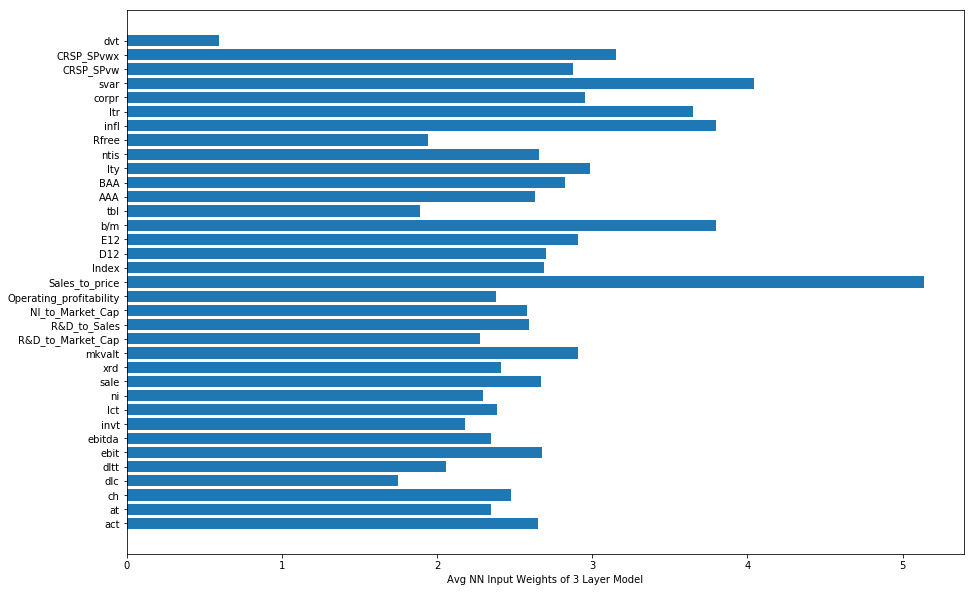

In [157]:
tick_label = list(dict_coef_nn.keys())
scalar = list(range(len(tick_label)))
height = [dict_coef_nn[k]/len(weight_storage) for k in tick_label]
plt.figure(figsize=(15,10))
plt.barh(scalar, height,linewidth = 10, tick_label= tick_label)
plt.xlabel('Avg NN Input Weights of 3 Layer Model')

In [158]:
# Neural Network Incl Lag1 Lag2 Lag3 Returns Variable Importance
# Test for 10 Stocks

tic_select_list = [77, 177, 277, 377, 477, 577, 677, 777, 877, 977]
ep = 200
act = 'sigmoid'
model_index = 3
weight_storage = []
for tic in tic_available[tic_select_list]:
    temp = get_data_by_date_range(df_clean, 20001031, 20191231, tic)
    temp = temp.drop(['tic'], axis =1)
    temp['trt1m'] = temp['trt1m']/100
    temp['past_trt1m_1'] = temp['trt1m']
    temp['past_trt1m_2'] = temp['trt1m'].shift(1)
    temp['past_trt1m_3'] = temp['trt1m'].shift(2)
    temp['trt1m'] = temp['trt1m'].shift(-1)
    temp = temp.dropna()
    temp.iloc[:,2:] = (temp.iloc[:,2:]-temp.iloc[:,2:].mean())/temp.iloc[:,2:].std()
    temp=temp.dropna(axis=1)

    train_index = int(0.4*len(temp))
    validate_index = int(0.8*len(temp))
    train = temp.iloc[:train_index,]
    validate = temp.iloc[train_index:validate_index,]
    test = temp.iloc[validate_index:,] 
    input_length= len(temp.columns)-2
    model = get_model(model_index, act)

    model.fit(train.iloc[:,2:], train['trt1m'], batch_size = 10, epochs = ep)
    weight_storage.append((train.columns[2:], np.sum(np.absolute(model.get_weights()[0]), axis = 1)))

Epoch 1/200
37/37 [==============================] - 13s 359ms/step - loss: 0.0115
Epoch 2/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0112
Epoch 3/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 4/200
37/37 [==============================] - 0s 1ms/step - loss: 0.0105
Epoch 5/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 6/200
37/37 [==============================] - 0s 1ms/step - loss: 0.0103
Epoch 7/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 8/200
37/37 [==============================] - 0s 1ms/step - loss: 0.0101
Epoch 9/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 10/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 11/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 12/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 13/200
37/37 [==============

37/37 [==============================] - 0s 2ms/step - loss: 0.0055
Epoch 103/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0054
Epoch 104/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0054
Epoch 105/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0055
Epoch 106/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 107/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 108/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 109/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 110/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 111/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 112/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 113/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 114/200
37/37 [=========

37/37 [==============================] - 0s 2ms/step - loss: 1.1646
Epoch 3/200
37/37 [==============================] - 0s 2ms/step - loss: 1.0411
Epoch 4/200
37/37 [==============================] - 0s 2ms/step - loss: 0.9282
Epoch 5/200
37/37 [==============================] - 0s 2ms/step - loss: 0.8256
Epoch 6/200
37/37 [==============================] - 0s 2ms/step - loss: 0.7340
Epoch 7/200
37/37 [==============================] - 0s 2ms/step - loss: 0.6506
Epoch 8/200
37/37 [==============================] - 0s 2ms/step - loss: 0.5771
Epoch 9/200
37/37 [==============================] - 0s 2ms/step - loss: 0.5127
Epoch 10/200
37/37 [==============================] - 0s 2ms/step - loss: 0.4544
Epoch 11/200
37/37 [==============================] - 0s 2ms/step - loss: 0.4033
Epoch 12/200
37/37 [==============================] - 0s 2ms/step - loss: 0.3582
Epoch 13/200
37/37 [==============================] - 0s 2ms/step - loss: 0.3190
Epoch 14/200
37/37 [============================

37/37 [==============================] - 0s 2ms/step - loss: 0.0172
Epoch 104/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 105/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 106/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 107/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 108/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 109/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 110/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 111/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 112/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 113/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 114/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 115/200
37/37 [=========

37/37 [==============================] - 0s 2ms/step - loss: 0.0359
Epoch 4/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0357
Epoch 5/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0363
Epoch 6/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0358
Epoch 7/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0344
Epoch 8/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0332
Epoch 9/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0330
Epoch 10/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0328
Epoch 11/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0325
Epoch 12/200
37/37 [==============================] - 0s 1ms/step - loss: 0.0321
Epoch 13/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0317
Epoch 14/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0314
Epoch 15/200
37/37 [===========================

37/37 [==============================] - 0s 1ms/step - loss: 0.0220
Epoch 105/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0222
Epoch 106/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0222
Epoch 107/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0218
Epoch 108/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0219
Epoch 109/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0218
Epoch 110/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0217
Epoch 111/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0216
Epoch 112/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0214
Epoch 113/200
37/37 [==============================] - 0s 1ms/step - loss: 0.0216
Epoch 114/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0215
Epoch 115/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0216
Epoch 116/200
37/37 [=========

37/37 [==============================] - 0s 2ms/step - loss: 0.0710
Epoch 5/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0532
Epoch 6/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0446
Epoch 7/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0407
Epoch 8/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0407
Epoch 9/200
37/37 [==============================] - 0s 1ms/step - loss: 0.0404
Epoch 10/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0409
Epoch 11/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0407
Epoch 12/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0399
Epoch 13/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0392
Epoch 14/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0387
Epoch 15/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0381
Epoch 16/200
37/37 [==========================

37/37 [==============================] - 0s 1ms/step - loss: 0.0232
Epoch 106/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0232
Epoch 107/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0233
Epoch 108/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0232
Epoch 109/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0230
Epoch 110/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0229
Epoch 111/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0228
Epoch 112/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0227
Epoch 113/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0227
Epoch 114/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0223
Epoch 115/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0223
Epoch 116/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0224
Epoch 117/200
37/37 [=========

37/37 [==============================] - 0s 2ms/step - loss: 0.0321
Epoch 6/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0325
Epoch 7/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0331
Epoch 8/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0332
Epoch 9/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0324
Epoch 10/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0316
Epoch 11/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0310
Epoch 12/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0303
Epoch 13/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0301
Epoch 14/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0297
Epoch 15/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0295
Epoch 16/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0294
Epoch 17/200
37/37 [=========================

37/37 [==============================] - 0s 2ms/step - loss: 0.0200
Epoch 107/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0200
Epoch 108/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0200
Epoch 109/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0200
Epoch 110/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0199
Epoch 111/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0198
Epoch 112/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0198
Epoch 113/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0198
Epoch 114/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0198
Epoch 115/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0197
Epoch 116/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0197
Epoch 117/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0196
Epoch 118/200
37/37 [=========

37/37 [==============================] - 0s 2ms/step - loss: 0.0297
Epoch 7/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0305
Epoch 8/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0307
Epoch 9/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0300
Epoch 10/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0292
Epoch 11/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0282
Epoch 12/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0278
Epoch 13/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0279
Epoch 14/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0277
Epoch 15/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0276
Epoch 16/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0274
Epoch 17/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0271
Epoch 18/200
37/37 [========================

37/37 [==============================] - 0s 2ms/step - loss: 0.0201
Epoch 108/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0201
Epoch 109/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0200
Epoch 110/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0201
Epoch 111/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0199
Epoch 112/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0199
Epoch 113/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0202
Epoch 114/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0198
Epoch 115/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0200
Epoch 116/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0200
Epoch 117/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0202
Epoch 118/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0197
Epoch 119/200
37/37 [=========

37/37 [==============================] - 0s 2ms/step - loss: 0.0985
Epoch 8/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0764
Epoch 9/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0585
Epoch 10/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0452
Epoch 11/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0353
Epoch 12/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0282
Epoch 13/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0235
Epoch 14/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0202
Epoch 15/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0182
Epoch 16/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 17/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0157
Epoch 18/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 19/200
37/37 [=======================

37/37 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 109/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 110/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 111/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 112/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 113/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 114/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 115/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0109
Epoch 116/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0109
Epoch 117/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 118/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 119/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 120/200
37/37 [=========

37/37 [==============================] - 0s 2ms/step - loss: 0.1087
Epoch 9/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0899
Epoch 10/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0787
Epoch 11/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0701
Epoch 12/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0664
Epoch 13/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0637
Epoch 14/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0628
Epoch 15/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0623
Epoch 16/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0621
Epoch 17/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0621
Epoch 18/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0620
Epoch 19/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0619
Epoch 20/200
37/37 [======================

37/37 [==============================] - 0s 2ms/step - loss: 0.0473
Epoch 110/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0471
Epoch 111/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0471
Epoch 112/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0468
Epoch 113/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0467
Epoch 114/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0466
Epoch 115/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0464
Epoch 116/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0462
Epoch 117/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0460
Epoch 118/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0460
Epoch 119/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0458
Epoch 120/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0455
Epoch 121/200
37/37 [=========

37/37 [==============================] - 0s 2ms/step - loss: 0.1163
Epoch 10/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0852
Epoch 11/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0623
Epoch 12/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0453
Epoch 13/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0336
Epoch 14/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0256
Epoch 15/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0209
Epoch 16/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0175
Epoch 17/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 18/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 19/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 20/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 21/200
37/37 [=====================

37/37 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 111/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 112/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 113/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 114/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 115/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 116/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 117/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 118/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 119/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 120/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 121/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 122/200
37/37 [=========

37/37 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 11/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 12/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 13/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 14/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0113
Epoch 15/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 16/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 17/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 18/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 19/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0109
Epoch 20/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0109
Epoch 21/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 22/200
37/37 [=====================

37/37 [==============================] - 0s 2ms/step - loss: 0.0080
Epoch 112/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0080
Epoch 113/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 114/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 115/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 116/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 117/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 118/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 119/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 120/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 121/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 122/200
37/37 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 123/200
37/37 [=========

In [159]:
# Plot NN Variable Importance
dict_coef_nn = {}
for ind, coef in weight_storage:
    for j in range(len(ind)):
        dict_coef_nn[ind[j]]= dict_coef_nn.get(ind[j],0) + abs(coef[j]) 

Text(0.5,0,'Avg NN Input Weights of 3 Layer Model')

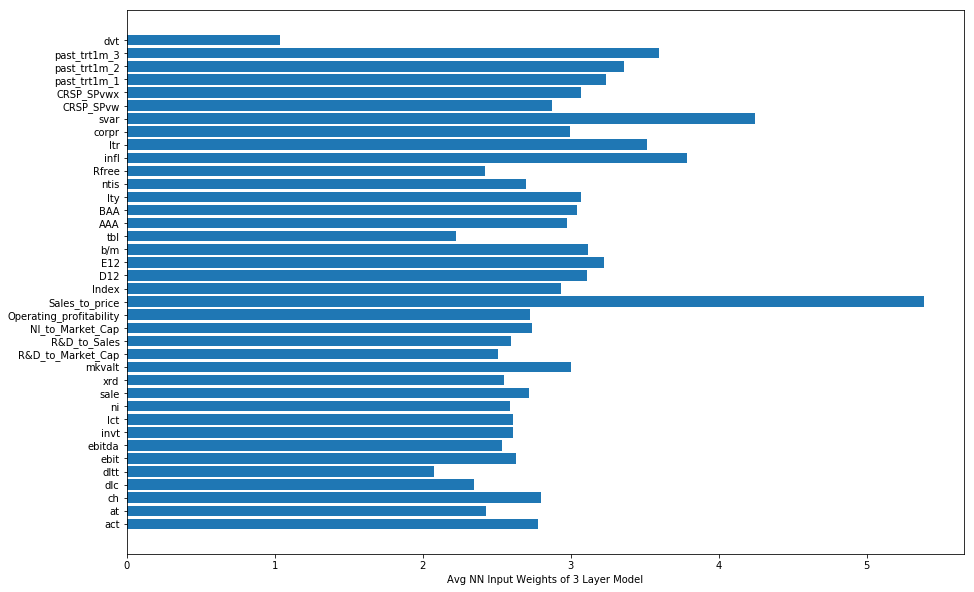

In [160]:
tick_label = list(dict_coef_nn.keys())
scalar = list(range(len(tick_label)))
height = [dict_coef_nn[k]/len(weight_storage) for k in tick_label]
plt.figure(figsize=(15,10))
plt.barh(scalar, height,linewidth = 10, tick_label= tick_label)
plt.xlabel('Avg NN Input Weights of 3 Layer Model')